In [14]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import pickle as pkl
import numpy as np 
import tensorflow as tf
import deepchem as dc
import pandas as pd
from multiprocessing import Pool
#import plotly.graph_objects as go


In [5]:
from deepchem.molnet import load_chembl
from deepchem.models import GraphConvModel

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
import deepchem.feat.fingerprints as fp

In [8]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit import Chem

Traceback (most recent call last):
  File "/miniconda/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


In [12]:
from __future__ import print_function

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

#import umap

## Benchmark with Random Matrix Theory Method

## ChemBL directly from the API

In [16]:
adrb = pd.read_csv('../data/ChemBL_ADRB1.csv', sep = ';')

In [17]:
ht1a = pd.read_csv('../data/ChemBL_5HT1A.csv', sep = ';')

In [18]:
adrb.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID'], dtype='object')

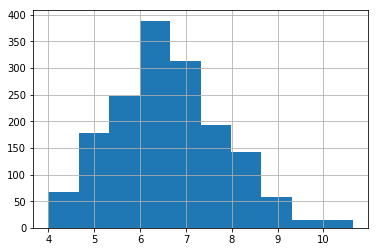

In [19]:
adrb['pChEMBL Value'].hist()

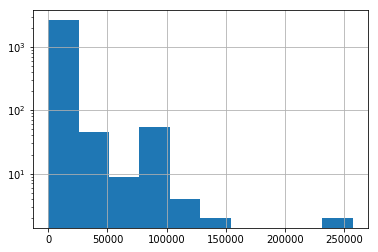

In [20]:
adrb['Standard Value'].hist(log = True)

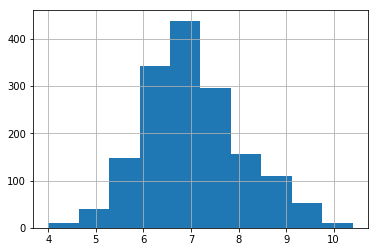

In [21]:
ht1a['pChEMBL Value'].hist()

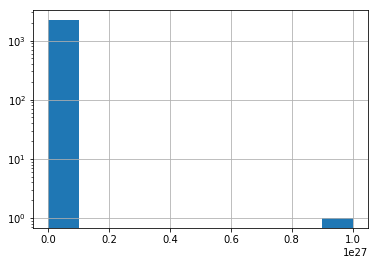

In [22]:
ht1a['Standard Value'].hist(log = True)

In [23]:
def clean_df(df, drop_non_binders = True):

    df_simple = df[['Molecule ChEMBL ID', 'Molecule Name',
                          'Uo Units', 'Ligand Efficiency BEI', 'Smiles',
                          'Standard Value', 'Standard Units']]

    df_simple['Standard Value'] = pd.to_numeric(df_simple['Standard Value'],
                                         errors = 'coerce')

    #df_simple = df_simple.dropna()
    df_simple = df_simple.reset_index(drop = True)

    #print(df_simple['Standard Units'].unique())
    
    df_simple = df_simple[df_simple['Standard Units'] == 'nM']

    
    df_simple = df_simple.dropna(subset = ['Smiles'])

    if drop_non_binders:
        df_simple = df_simple[df_simple['Standard Value'] < 1000]

    df_simple = df_simple.drop_duplicates(subset = 'Smiles',
                                          keep = 'first')
    
    return df_simple

In [24]:
clean_ardb = clean_df(adrb)
clean_ht1a = clean_df(ht1a, drop_non_binders = False)

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [25]:
clean_ardb.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Uo Units', 'Ligand Efficiency BEI', 'Smiles', 'Standard Value', 'Standard Units'], dtype='object')

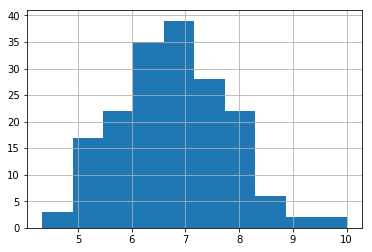

In [26]:
chembl = pd.read_csv('../data/chembl_5thresh.csv')
chembl.iloc[:,list(chembl.columns).index('CHEMBL213')].hist()

## Reading and transforming DB data

In [17]:
drugbank = pkl.load(open('data/Corona_Gene_Embeddings.pkl', 'rb'))

In [18]:
drugbank

,Gene,Gene_Name,Entrez_ID,Target_DB_ID,AA_Sequence,Gene_Sequence,Gene_FingerPrint,Target_EMbedding
0,ACADM,"Medium-chain specific acyl-CoA dehydrogenase, ...",34.0,BE0001745,>lcl|BSEQ0003460|Medium-chain specific acyl-Co...,>lcl|BSEQ0021302|Medium-chain specific acyl-Co...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.0008826057 -0.0018619265 0.0005886211 0.0001...
1,GGCX,Tissue factor,2677.0,BE0001178,>lcl|BSEQ0002343|Tissue factor\nMETPAWPRVPRPET...,>lcl|BSEQ0021656|Tissue factor (F3)\nATGGAGACC...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.0004959933 -0.0015191967 0.0004373464 -0.000...
2,ATP6V1A,V-type proton ATPase catalytic subunit A,523.0,BE0003569,>lcl|BSEQ0006875|V-type proton ATPase catalyti...,>lcl|BSEQ0012482|V-type proton ATPase catalyti...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.00046752422 -0.0017994677 0.0003406349 -0.00...
3,TARS2,"Threonine--tRNA ligase, mitochondrial",80222.0,BE0002317,">lcl|BSEQ0004550|Threonine--tRNA ligase, mitoc...",>lcl|BSEQ0004549|2157 bp\nATGGCCCTGTATCAGAGGTG...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.0007386954 -0.0014467473 0.00034487134 -0.00...
4,AASS,"Glutamate receptor ionotropic, kainate 3",10157.0,BE0000832,>lcl|BSEQ0037089|Glutamate receptor ionotropic...,>lcl|BSEQ0010587|Glutamate receptor ionotropic...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.00022724312 -0.00087777985 -3.299319e-05 -0....
5,CSNK2A2,Casein kinase II subunit alpha',1459.0,BE0003984,>lcl|BSEQ0012773|Casein kinase II subunit alph...,>lcl|BSEQ0012774|Casein kinase II subunit alph...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.00063122425 -0.001525819 0.000564763 -0.0007...
6,POLA1,Purine nucleoside phosphorylase,5422.0,BE0000250,>lcl|BSEQ0010033|Purine nucleoside phosphoryla...,>lcl|BSEQ0010034|Purine nucleoside phosphoryla...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.00042263846 -0.0014812584 0.00028048162 -3.6...
7,POLA2,"6-phosphogluconate dehydrogenase, decarboxylating",23649.0,BE0003559,>lcl|BSEQ0006857|6-phosphogluconate dehydrogen...,>lcl|BSEQ0020701|6-phosphogluconate dehydrogen...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.0004616005 -0.0010432433 0.00059503893 -0.00...
8,GFER,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,2671.0,BE0000305,>lcl|BSEQ0000607|NADH dehydrogenase [ubiquinon...,>lcl|BSEQ0010072|NADH dehydrogenase [ubiquinon...,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,0.0001736389 -0.0013006188 -1.8839728e-05 -0.0...
9,BCKDK,Cag alpha,10295.0,BE0002850,>lcl|BSEQ0022302|Cag alpha\nMTEDRLSAEDKKFLEVER...,>lcl|BSEQ0005579|993 bp\nCTACCTATGTTTGATATAAAA...,[0.0001882191 0.00042436537 -0.0014462507 -0.0...,-0.0011031309 -0.001748469 0.00023615667 6.136...


In [ ]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))



## Getting rdkit molecule objects

In [27]:
#fp_obj = fp.CircularFingerprint(radius = 2, size = 2048, bonds = True)
#fp_obj._featurize(clean_ardb['Smiles'].tolist()[0])

In [28]:
def get_morgan_matrix(smile):   
    
    compound = Chem.MolFromSmiles(smile)
    fp       = Chem.AllChem.\
                GetMorganFingerprintAsBitVect(compound,
                                              2, nBits = 2048)
    return [int(i) for i in fp.ToBitString()]

In [29]:
p = Pool(2)

clean_ardb['Morgan'] = p.map(get_morgan_matrix, clean_ardb['Smiles'].tolist())
clean_ht1a['Morgan'] = p.map(get_morgan_matrix, clean_ht1a['Smiles'].tolist())

In [30]:
clean_ardb['Y'] = clean_ardb['Standard Value'].apply(lambda x: 0 if x < 1000 else 1)

In [31]:
clean_ht1a['Y'] = clean_ht1a['Standard Value'].apply(lambda x: 0 if x < 1000 else 1)

In [32]:
X = clean_ardb['Morgan'].append(clean_ht1a['Morgan'])
y = clean_ardb['Y'].append(clean_ht1a['Y'])

X = np.array([np.array(i) for i in X.values])

In [33]:
X_train, X_test, \
y_train, y_test = train_test_split(X, y)

In [35]:
X_train.shape

(1914, 2048)

In [36]:
X_test.shape

(638, 2048)

In [37]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

/miniconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [40]:
projection(X_train[0], 2)

TypeError: projection() missing 2 required positional arguments: 'p' and 'feature_vecs'

In [38]:
def projection(trial_molecule, feature_vecs):
    
    p     = len(trail_molecule)
    dim_V = 3
    
    trial_molecule_proj = np.zeros(p)
    
    for i in range(dim_V):
        
        dotprod = float(np.vdot(feature_vecs[:i], trial_molecule))
        trial_molecule_proj = trial_molecule_proj + dotprod * feature_vecs[:, i]
    
    return np.array([float(i) for i in trial_molecule_proj])

In [133]:
class RMTClassifier(object):
    
    """
    Referred https://github.com/aced125/FCC_DNN_Ligand_Classification
    """
    
    def __init__(self,threshold_multiple = 1, cutoff = 0.95):
        self.cutoff = cutoff
        self.thresh_multiple = threshold_multiple
        

    def _RMT(self, matrix):
        N, p = matrix.shape
        
        gamma = p/N
        thresh = ((1 + np.sqrt(gamma))**2)*self.thresh_multiple
        
        scaler = StandardScaler()
        matrix = scaler.fit_transform(matrix)
        pca = PCA()
        pca.fit_transform(matrix)
        
        # Find significant vector space V
        dim_V = pca.explained_variance_[pca.explained_variance_>thresh].shape[0]
        
        return scaler, pca, dim_V
    
    def _distance_to_projection(self, data, vector_space):
        # Given a vector space, V, we project the data onto that vector space, and then return distance to
        # the original data
        
        # V is formatted such that different vectors are along different columns
        
        # Data matrix is formatted such that rows correspond to different data points
        # and columns correspond to different features
        
        # projected_matrix = D V V.T
        #
        # finally, subtract original data (projectect_matrix - D) take euclidean norm along columns 
        
        # Also note that the vector space can be as large/small as required
                
        return np.linalg.norm( np.dot(data, 
                                      np.dot( vector_space, vector_space.T ) )  - data,
                             axis = 1)
    
    def _distance(self, data, vector_space):
        return np.dot(data, np.dot(vector_space,vector_space.T)) - data
    
    def fit(self, X,y):
        
        X,y = np.array(X), np.array(y)
        actives = X[np.where(y==1)[0],:]
        inactives = X[np.where(y==0)[0],:]
        
        self.scaler_actives, self.pca_actives, self.dim_V_actives = self._RMT(actives)
        self.scaler_inactives, self.pca_inactives, self.dim_V_inactives = self._RMT(inactives)
        
        metric = self.predict_scores(actives)
        
        idx = np.argsort(metric) #sorts in ascending order
        metric = metric[idx]
        cutoff_idx = int(self.cutoff * len(metric))
        self.epsilon = metric[cutoff_idx]

    
    def predict_scores(self, X_test):
        # https://www.pnas.org/content/116/9/3373
        self.scores = (self._distance_to_projection(self.scaler_actives.transform(X_test), 
                                                 self.pca_actives.components_.T[:, :self.dim_V_actives])
                  - 
                  
                 self._distance_to_projection(self.scaler_inactives.transform(X_test), 
                                                 self.pca_inactives.components_.T[:, :self.dim_V_inactives]))
        return self.scores
    
    def projection(self, X):
        return self._distance(self.scaler_actives.transform(X), 
                                                 self.pca_actives.components_.T[:, :self.dim_V_actives])
    
    def predict(self, X_test, epsilon_multiple = 1):
        
        scores = self.predict_scores(X_test)
        predictions = np.array([1 if x<self.epsilon * epsilon_multiple else 0 for x in scores])
        
        return predictions
    
    def return_indices_of_common_molecules_of_active_eig(self, matrix, n=5,eigenvector_index=0):
        
        # returns molecules that lie closest to the selected eigenvector
        # default number of molecules returned = 5
        
        # Pick out the (best) eigenvector
        
        eig = self.feature_vecs[:,eigenvector_index].reshape(self.p,1)
        
        #Project molecules onto the one-dimensional vector space and get the indices of the top 5 molecules
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        return np.argpartition(    np.dot(matrix, eig).reshape(matrix.shape[0])   , -n)[-n:]

In [134]:
clf = RMTClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test, epsilon_multiple = 1)

print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test,test_preds))

confusion_matrix 
 [[437  71]
 [ 65  65]]
             precision    recall  f1-score   support

          0       0.87      0.86      0.87       508
          1       0.48      0.50      0.49       130

avg / total       0.79      0.79      0.79       638



In [91]:
clf.projection(X_train).shape

(1914, 2048)

In [135]:
test_preds

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [92]:
X_train.shape

(1914, 2048)

In [93]:
clf.pca_inactives.components_.shape

(1504, 2048)

## Try the same data with the Fully Connected Method

In [94]:
clf.projection(X_train) == X_train

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [95]:
keras.utils.to_categorical(np.array(y_train), 2)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [96]:
batch_size = 128
num_classes = 2
epochs = 20


In [97]:
y_train = keras.utils.to_categorical(np.array(y_train), num_classes)
y_test = keras.utils.to_categorical(np.array(y_test), num_classes)

y_train = np.apply_along_axis(lambda x:1-x, 0, y_train)
y_test = np.apply_along_axis(lambda x:1-x, 0, y_test)

In [99]:
model = Sequential()
model.add(Dense(512, activation = 'relu',input_shape = (2048,)))
model.add(Dense(4096, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = 'tanh'))
model.add(Dense(4096,activation = 'tanh'))
model.add(Dense(4096,activation = 'tanh'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))

print(model.summary())

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

history = model.fit(X_train,y_train,
                   batch_size = 128,
                   epochs = 10,
                   verbose = 1,
                   validation_data = (X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_22 (Dense)             (None, 4096)              2101248   
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_24 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_26 (Dense)             (None, 512)               2097664   
__________

In [103]:
model.predict(X_train)

array([[1.3068413e-29, 1.0000000e+00],
       [1.3702477e-29, 1.0000000e+00],
       [3.4183447e-30, 1.0000000e+00],
       ...,
       [2.5650734e-28, 1.0000000e+00],
       [2.0599132e-30, 1.0000000e+00],
       [5.4107768e-30, 1.0000000e+00]], dtype=float32)

In [109]:
np.argmax(model.predict(X_test), axis = 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [108]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [107]:
print('confusion_matrix \n',confusion_matrix(y_test, test_preds))
print(classification_report(y_test,model.predict(X_train)))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1646562620978058306
]


In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [10]:
tf.__version__

'1.8.0'

In [11]:
keras.__version__

'2.2.4'

In [ ]:
y_train = keras.utils.to_categorical(np.array(y_train), num_classes)
y_test = keras.utils.to_categorical(np.array(y_test), num_classes)

y_train = np.apply_along_axis(lambda x:1-x, 0, y_train)
y_test = np.apply_along_axis(lambda x:1-x, 0, y_test)

In [54]:
model = Sequential()
model.add(Dense(512, activation = 'relu',input_shape = (2048,)))
model.add(Dense(4096, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = 'tanh'))
model.add(Dense(4096,activation = 'tanh'))
model.add(Dense(4096,activation = 'tanh'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

history = model.fit(clf.projection(X_train),y_train,
                   batch_size = 128,
                   epochs = 10,
                   verbose = 1,
                   validation_data = (clf.projection(X_test), y_test))



Train on 1914 samples, validate on 638 samples
Epoch 1/10
1914/1914 [==============================] - 19s 10ms/step - loss: 3.1993 - acc: 0.7618 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 2/10
1914/1914 [==============================] - 18s 10ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 3/10
1914/1914 [==============================] - 19s 10ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 4/10
1914/1914 [==============================] - 21s 11ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 5/10
1914/1914 [==============================] - 21s 11ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 6/10
1914/1914 [==============================] - 20s 11ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
Epoch 7/10
1914/1914 [==============================] - 20s 10ms/step - loss: 3.3348 - acc: 0.7931 - val_loss: 3.4106 - val_acc: 0.7884
E

### Fully Connected Network Appears to Have the Exact same accuracy trying to classify RMT and the raw matrix

## Visualizing

In [62]:
umap_model = umap.UMAP(n_components = 3, n_neighbors = 100)
X_test_umap = umap_model.fit_transform(X_test)

umap_model = umap.UMAP(n_components = 3, n_neighbors = 100)
X_test_rmt_umap = umap_model.fit_transform(clf.projection(X_test))

/miniconda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



In [61]:
X_test_umap[:,1].shape

(638,)

In [70]:
fig = go.Figure(data=[go.Scatter3d(
                        x=X_test_umap[:,0],
                        y=X_test_umap[:,1],
                        z=X_test_umap[:,2],
                        mode='markers',
                        marker=dict(
                                    size       = 3,
                                    color      = y_test,                
                                    colorscale = 'Bluered',   
                                    opacity     = 0.2
                                    )
                                )])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [69]:
fig = go.Figure(data=[go.Scatter3d(
                        x=X_test_rmt_umap[:,0],
                        y=X_test_rmt_umap[:,1],
                        z=X_test_rmt_umap[:,2],
                        mode='markers',
                        marker=dict(
                                    size       = 3,
                                    color      = y_test,                
                                    colorscale = 'Bluered',   
                                    opacity     = 0.2
                                    )
                                )])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### Graph Conv Method